<a href="https://colab.research.google.com/github/kodiakpony/datakit-housing-fall-2024/blob/main/challenge-3/DataKindChallenge3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fall 2024 DataKit Housing Challenge \#3 - Florida Analysis

For the past six weeks, I have been participating in [DataKind's Fall 2024 DataKit](https://github.com/datakind/datakit-housing-fall-2024
), investigating challenges around affordable housing.  I have been focusing on [Challenge \#3](https://github.com/datakind/datakit-housing-fall-2024/discussions/3) in Florida, looking at the availability of government housing programs in different census tracts and how it relates to mortgage origination and CDFI lending rates, economic and demographic factors and environmental hazards.

My path has been winding and learning curve steep, and you can see its [messy glory in a different notebook](https://github.com/kodiakpony/datakit-housing-fall-2024/tree/main/challenge-3/DataKindHousingChallenge3Messy.ipynb), in which I explore Folium interactive maps and plotly interactive plots and experiment with different ways to visualize the data. It also goes spelunking into the CDFI lending source dataset. It's not very coherent but is very long and has a "newbie" notes section in the appendix with links to things I've found useful.

This notebook is my attempt at a coherent analysis of the "getting started" questions for DataKit's Challenge \#3, that can be read and understood by anyone interested in the topic, using the visualizations I find most helpful. It is also quite long, but I hope you will find it readable and interesting. It has four main sections:
* Number of Mortgages and Total CDFI Lending
* Government Housing Programs
* Poverty and Race
* Environmental Risk Factors

I use Python Pandas for data manipulation and rely heavily on Seaborn (built on top of Matplotlib) for the visualizations. (I would have liked to include plotly interactive plots for some of the visualizations, but couldn't find a way to get plotly graphs to work in both Google Colab and Jupyter NBViewer at the same time due to how they handle JavaScript, so I use static
Seaborn visualizations in this notebook.)

This notebook uses the Florida dataset (version 1.1) provided as part of the DataKit. It is augmented with census data containing the total population and number of households per census tract, obtained separately from census.gov.

Both datasets use 2020 census tract boundaries and are indexed by census tract geoid. These geoids have 11 digits - the first 2 indicate the state, next 3 the county, and last 6 the tract within the county. (If you find a dataset whose geoids don't have 11 digits, they are NOT census tract geoids!)

**Future Work**

(I'm putting Future Work here in case you don't read all the way to the end)

* One thing that surprised me when doing this analysis is just how unevenly CDFI lending is distributed, and how differently counties handle their allocations. It makes sense, given that individual CDFIs operate locally and have different lending priorities, but I didn't realize that going in and didn't focus on it a lot in this notebook. It would be interesting to dig into this more from a county perspective (or per CDFI perspective if possible) to evaluate how effectively each is serving their populations. (From what I've seen so far, Hillsborough County is the winner)

* I'm worried about how trustworthy the DataKit CDFI lending data is. The source dataset referenced in EODataScape uses 2010 census ids and DataKit uses 2020 census ids and there is a big gap in the total lending reported between the two datasets (2.4 billion dollars in DataKit vs 1.5 billion dollars in CDFI LTR). I don't know how the data got converted to 2020 census ids when brought into DataKit, but I suspect it introduced some overcounting. This needs to be investigated and until it is understood, the DataKit/EODataScape CDFI lending numbers ([EODataScape](https://eodatascape.datakind.org/data-dictionary) field name "loan_amount") should be taken with a grain of salt.

* This notebook doesn't include any maps or interactive graphics. It looks at aggregations of things, rather than providing insight into individual census tracts. I'm not sure whether it addresses the concerns of individual stakeholders. I do have an [interactive Folium map in another notebook](https://github.com/kodiakpony/datakit-housing-fall-2024/blob/main/challenge-3/DataKindHousingChallenge3GeoMaps.ipynb), and a lot of thoughts on what I'd like to do with interactive tools (probably using MapBox, Folium and plotly) that I haven't written down yet but will put there if I have time. This is what I would work on next if today wasn't the last day of the DataKit. There are some great tools already that are worth taking a look at: [CDFI Fund CIMS Mapping Tool](https://www.cdfifund.gov/cims), [Justice40 Screening Tool](https://justice40.cnt.org/)

* This notebook only addresses the "getting started" questions in Challenge 3. There is a lot more to dig into in their ["take it further"](https://github.com/datakind/datakit-housing-fall-2024/discussions/3) section.

* I could do a better job at data cleanup in this notebook. I mostly took the simple approach of dropping census tracts that had missing data in any of the fields I cared about, but that adds up to a few percent. I could have been more careful to only exclude census tracts when their missing data was relevant to a particular analysis.


Finally, I'd like to say a big THANK YOU to [Data Kind](https://www.datakind.org/) for running this DataKit Housing Challenge. I have learned a ton and appreciate the organizers being so responsive to my gazillion questions. This was my first time participating in something like this and I'm glad I did. I hope this work ends up being useful.

Now, let's look at some data...



## Setup

*Import libraries, read in datasets*


We import:

*   Python Pandas for data manipulation
*   Seaborn (built on top of Matplotlib) for most of our visualizations
*   matplotlib_venn for making Venn diagrams
*   zipfile, requests, io for fetching and reading the datasets


In [ ]:
# import libraries

%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib_venn import venn2,venn2_circles,venn3, venn3_circles, layout
import seaborn as sns
import zipfile
import requests, io

#import numpy as np
#import geopandas as gpd
#import folium
# from mpl_toolkits.axes_grid1 import make_axes_locatable

Next we read in the [1.1 version of DataKind's Fall 2024 housing dataset](https://github.com/datakind/datakit-housing-fall-2024/releases/tag/v1.1), which was provided by DataKind for use in the DataKit event.

Version 1.1 has different column names than the 1.0 version, and so is not consistent with the [EODatascape data dictionary](https://www.google.com/url?q=https%3A%2F%2Feodatascape.datakind.org%2Fdata-dictionary). It is generally obvious from the column names which ones they correspond to. (Version 1.0 had incomplete data -- less than 2000 of Florida's >5000 census tracts)

We rename some of the columns to be consistent with v1.0 naming conventions, but not all of them.

We also do a bit of data cleanup, dropping a small number of census tracts with bogus values, and adding some new columns that will be convenient for making visualizations.


In [ ]:
# Read DataKind EODataScape housing dataset into Panda dataframe df

version=1.1
url = f"https://github.com/datakind/datakit-housing-fall-2024/releases/download/v{version}/housing-data.zip"
filename = "housing-data/FL/data_1-FL.csv"

r = requests.get(url)

with zipfile.ZipFile(io.BytesIO(r.content)) as myzip:
    with myzip.open(filename) as myfile:
        df = pd.read_csv(myfile)

# rename some columns because the original dataset used different names than the current one and I don't want to change everything
# don't do renaming if using the v1.0 dataset
if(version==1.1):
  column_renames={
      "hud_opportunity_zones" : "opzone",
      "cdfi_fund_invest_areas" : "investment_areas",
      "lihtc_qualified_tracts" : "qct",
      "cdfi_fund_economic_distress" : "economic_distress_pop_agg",
      "county" : "county_name",
      "county_fips_code" : "county",
  }
  df=df.rename(columns=column_renames)

# add a boolean column for whether a census tract has non-negligible CDFI lending
df["has_cdfi_lending"]=df.total_cdfi_lending.apply(lambda x: x>10000)

# make "cdfi_fund_invest_areas" a clone of "investment_areas"
df["cdfi_fund_invest_areas"]=df.investment_areas

# change "investment_areas" from YES/NO to 1/0,
df["investment_areas"]=df.investment_areas.apply(lambda x: 1 if x=="YES" else 0)

#  add a column indicating which set of government programs a Census tract belongs to (CDFI Investment Areas, HUD Qualified Census Tract, HUD Opportunity Zone)
#  values are like "101", "010" etc indicating membership in investment_areas, opzone, and qct by digit
df["venn_key"]=df.apply(lambda x: str(x.investment_areas)[0]+str(x.opzone)[0]+str(x.qct)[0],axis=1)

# make a human friendly versions of that column, combining the rare values, to be used for pie charts and histograms
df["overlap_label"]=df.venn_key.map({
    "000":"none",
    "100":"ia",
    "101":"ia+qct",
    "111":"all",
    "110":"ia+op",
    "011":"other",
    "010":"other",
    "001":"other"
})

df["overlap_label2"]=df.venn_key.map({
    "000":"none",
    "100":"ia only",
    "101":"hud",
    "111":"hud",
    "110":"hud",
    "011":"hud",
    "010":"hud",
    "001":"hud"
})

# add a similar column combinining investment_areas, has_cdfi_lending, and economic_distress
df["venn_ia_hl_ed"]=df.apply(lambda x: str(x.investment_areas)[0]+str("1" if x.has_cdfi_lending else "0")[0]+str("1" if x.economic_distress_pop_agg=="YES" else "0")[0],axis=1)

# drop rows for which total_cdfi_lending or num_mortgages_origin is not defined
display(f"dropping rows with missing total_cdfi_lending: {df.total_cdfi_lending.isna().sum()}")
display(f"dropping rows with missing num_mortgages_origin: {df.num_mortgages_origin.isna().sum()}")
df.dropna(subset=["num_mortgages_origin","total_cdfi_lending"],inplace=True)

# set percentile columns for cdfi lending and num mortages originated
df["pctile_cdfi_lending_fl"]=df.total_cdfi_lending.rank(pct=True)*100
df["pctile_mortgages_origin_fl"]=df.num_mortgages_origin.rank(pct=True)*100

df.head().T

'dropping rows with missing total_cdfi_lending: 124'

'dropping rows with missing num_mortgages_origin: 83'

,0,1,2,3,4
geoid,12001000600,12001000809,12001001100,12001001202,12001001519
geoid_year,2020,2020,2020,2020,2020
state,Florida,Florida,Florida,Florida,Florida
county_name,Alachua County,Alachua County,Alachua County,Alachua County,Alachua County
state_fips_code,12,12,12,12,12
...,...,...,...,...,...
overlap_label,all,ia+qct,none,none,ia+qct
overlap_label2,hud,hud,none,none,hud
venn_ia_hl_ed,111,101,010,010,111
pctile_cdfi_lending_fl,17.38176,0.967871,20.933945,99.620834,12.133307


Next we read in a dataset downloaded from census.gov and stored in Github which contains the population and number of households per census tract, and merge it with the DataKind dataset.

This results in a few more census tracts being dropped, but not many.

In [ ]:
# read in the dataset downloaded from census.gov, which has population and number of households per census tract

url="https://raw.githubusercontent.com/datakind/datakit-housing-fall-2024/refs/heads/main/challenge-3/FL/DECENNIALDP2020.DP1_2024-10-12T222820/DECENNIALDP2020.DP1-Data.csv"

population_df_columns={
    "GEO_ID":"full_geoid",
    "NAME":"full_name",
    "DP1_0001C":"total_population",
    "DP1_0132C":"total_households"
}

# the first two rows of the dataset are column descriptions and Florida-wide totals. Ignore them, as well as unneeded columns in dataframe
# need to set low_memory=False to avoid a warning because columns have mixed datatypes because of the first two rows being special
dfpop = pd.read_csv(url,low_memory=False).loc[2:,[*population_df_columns]].rename(columns=population_df_columns)

# make population and households columns numeric, now we've dropped the descriptions row
dfpop.total_population=dfpop.total_population.astype(int)
dfpop.total_households=dfpop.total_households.astype(int)

# the dataset uses fully qualified geoids that encode country, with format:
# 1400000US12001000201
# we just want the last 11 digits for consistency with other dataset
dfpop["geoid"]=dfpop["full_geoid"].apply(lambda x: x.split("US")[1]).astype(int)

display("census population dataset: ",dfpop.head())

# merge into main dataframe
display("merging population totals data into main dataframe")
display("dfpop shape:",dfpop.shape, "df shape: ",df.shape)
df=df.merge(dfpop,on="geoid",how="left")
display("merged df shape: ", df.shape)

'census population dataset: '

,full_geoid,full_name,total_population,total_households,geoid
2,1400000US12001000201,Census Tract 2.01; Alachua County; Florida,4348,1711,12001000201
3,1400000US12001000202,Census Tract 2.02; Alachua County; Florida,4782,1695,12001000202
4,1400000US12001000301,Census Tract 3.01; Alachua County; Florida,3384,1808,12001000301
5,1400000US12001000302,Census Tract 3.02; Alachua County; Florida,2644,1257,12001000302
6,1400000US12001000400,Census Tract 4; Alachua County; Florida,5330,2117,12001000400


'merging population totals data into main dataframe'

'dfpop shape:'

(5160, 5)

'df shape: '

(5011, 392)

'merged df shape: '

(5011, 396)

## Number of Mortgages and Total CDFI Lending

This section looks at the first [Challenge 3 Getting Started](https://github.com/datakind/datakit-housing-fall-2024/discussions/3) bullet item:


> *Create an understanding of initial funding distributions - where CDFI lending is reported and the number of mortgages originated at a Census tract level using EODatascape variables Total CDFI Lending Reported (CDFI Fund Transaction Level Report) and Number of Mortgages Originated (HMDA LAR).*



In the v1.1 dataset, these are columns **total_cdfi_lending** and **num_mortgages_origin**.  They correspond to columns *loan_amount*
 and *num_mortgage_originated* in the v1.0 dataset and DataKind's [EODataScape data dictionary](https://eodatascape.datakind.org/data-dictionary)

*loan_amount* is Total CDFI Lending Reported (in the [FY2021 CDFI Fund Transaction Level Report](https://www.cdfifund.gov/sites/cdfi/files/2023-07/FY2021_Data_Documentation_Instruction.zip)). The data source is U.S. Department of the Treasury Community Development Financial Institutions Fund (CDFI Fund), and column description is "original loan/investment amount".

*num_mortgage_originated* has description "number of mortgages reported as originated (HMDA LAR)" and is 2023 data from the [FFIEC Modified Loan/Application Register (LAR)](https://ffiec.cfpb.gov/data-publication/modified-lar/2023) set up as part of the Home Mortgage Disclosure Act (HDMA).

Some important things to understand about this data that I hadn't realized at first and can cause confusion:

1.  *num_mortgages_origin* includes all mortgages that get originated in a census tract, regardless of whether there was any CDFI or government funding assistance.

2. CDFI lending doesn't only go to CDFI investment areas. CDFIs need to give a certain percentage of their funding (40%? 60%?) to recipients who are either in a CDFI investment area or otherwise belong to that CDFI's target constituency based on their income, race etc. [cdfi.org/what-are-cdfis/](https://cdfi.org/what-are-cdfis/) provides helpful background on Community Development Financial Institutions and their relationship to the US Treasury's CDFI Fund.

3.  CDFI lending isn't just to help people buy homes. A large chunk of CDFI lending goes to businesses and construction, and CDFI also provides microloans. *total_cdfi_lending (loan_amount)* includes all of these things together. (They are broken out separately in the CDFI Fund Transaction Level Report - the source dataset for *total_cdfi_lending*).

4.  The CDFI Fund Transaction Level Report (used for *total_cdfi_lending*) uses 2010 census tract geoids, but EODataScape uses 2020 census tract ids, so sadly it isn't easy to merge in.

5. There must have been some geoid remapping done to get *loan amount* in EODataScape given that the source data uses 2010 census ids. The sum of *total_cdfi_lending* in the DataKind dataset is significantly higher than in the source dataset, which makes me think that the remapping was done by adding together the loan_amount values of all 2010 census tract ids that overlap a given 2020 census tract id. I haven't followed up on this, but I suspect this may skew the *total_cdfi_lending* values quite a bit. It would be really nice to have CDFI data based on 2020 census ids but there does not appear to be any available.

6. The CDFI Fund Transaction Level Report has lots of useful information, including which funding was for home purchases vs businesses vs construction, the size of individual loans, demographics about the loan recipient (income level, race etc), and the CDFI that originated the loan. I dug into the data quite a bit before noticing that it uses 2010 census ids. I had been hoping to use it to get total CDFI home mortgage lending as well as the number of CDFI funded home mortgages per census tract, which seems very useful for some of these analyses.  

7. You can find my spelunking into the CDFI TLR dataset in the "*CDFI loan dataset setup and initial analysis*" and "*A detour into the CDFI LAR dataset again*" sections of [my messy challenge 3 colab notebook](https://github.com/kodiakpony/datakit-housing-fall-2024/blob/main/challenge-3/DataKindHousingChallenge3Messy.ipynb).



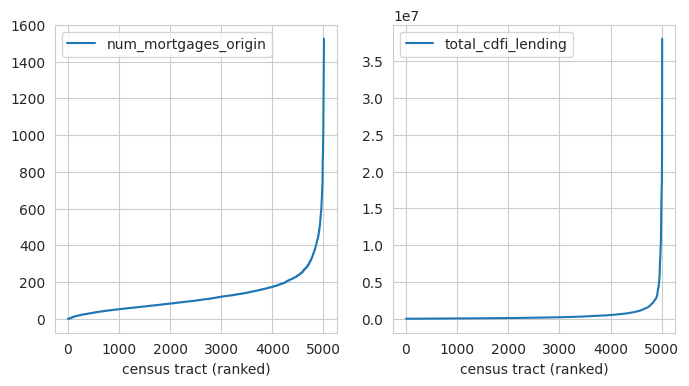

In [ ]:
# Create subplots
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(8,4))

df.num_mortgages_origin.sort_values(ascending=True).reset_index().plot(y="num_mortgages_origin",ax=axes[0],xlabel="census tract (ranked)")

df.total_cdfi_lending.sort_values(ascending=True).reset_index().plot(y="total_cdfi_lending",ax=axes[1],xlabel="census tract (ranked)")

plt.show()

**Discussion**

Above, we plot *num_mortgages_origin* and *total_cdfi_lending* after sorting census tracts by those variables. You can see that we have about 5000 census tracts total.

The plots let us see the extreme tail values for each of these variables. e.g over 4000 census tracts have < 200 mortgages originated but some have over 1400. For total CDFI lending the tail is even more extreme, with over 4500 having less than 2 million dollars in spending but some having over 35 million dollars.

This means that care must be taken when looking at how total CDFI lending and mortgages are apportioned amongst different categories of census tracts, since a small percentage of census tracts can dominate the totals and skew the results significantly. Rather than the sum of CDFI lending across a category, it may be more useful to look at histograms, scatterplots or percentiles, or to exclude the highest percentiles from the aggregation.

The query below shows that 27% of total CDFI lending for the state of Florida goes to 1% of census tracts (and 7% of mortgages are originated in 1% of census tracts)



In [ ]:
q=df.loc[:,["num_mortgages_origin","total_cdfi_lending"]].quantile([0.99])

percent_cdfi_funding_in_top_1_percent = df.total_cdfi_lending[df.total_cdfi_lending>=q.loc[0.99,"total_cdfi_lending"]].sum()*100/df.total_cdfi_lending.sum()

percent_mortgages_in_top_1_percent = df.num_mortgages_origin[df.num_mortgages_origin>=q.loc[0.99,"num_mortgages_origin"]].sum()*100/df.num_mortgages_origin.sum()

display(
    "percentiles:",q,
    "percentage of total contained in the top 1% of census tracts:",
    f"num_mortgages: {percent_mortgages_in_top_1_percent:0.1f}%",
    f"CDFI funding: {percent_cdfi_funding_in_top_1_percent:0.1f}%"
    )

'percentiles:'

,num_mortgages_origin,total_cdfi_lending
0.99,604.7,6.064774e+06


'percentage of total contained in the top 1% of census tracts:'

'num_mortgages: 7.2%'

'CDFI funding: 27.4%'

I am curious about what is causing 1% of census tracts to get over a quarter of all CDFI lending. There may be some skew in the data due to 2010 census ids, but that isn't the main culprit. I saw similarly large values in the source CDFI dataset.

My investigations there found a single commercial real estate loan for 37 million dollars in May 2021 that accounts almost the entire lending for the maximum lending census tract. There were also home loans over 1 million dollars each in other places that can quickly add up.

The source CDFI dataset lists an "org_id" associated with the CDFI that provided the loan, but I couldn't find a way to tie it back to the name or location of the organization itself. That said, I've heard that many CDFIs are regional, only serving a few counties.

You can see details in the "*A detour into the CDFI LAR dataset again*" section of [my messy challenge 3 colab notebook](https://github.com/kodiakpony/datakit-housing-fall-2024/blob/main/challenge-3/DataKindHousingChallenge3Messy.ipynb).

We aren't using the CDFI TLR dataset in this notebook. Instead, we look at the county distribution of the top 1% of CDFI lending census tracts, to see if it gives us any clues.


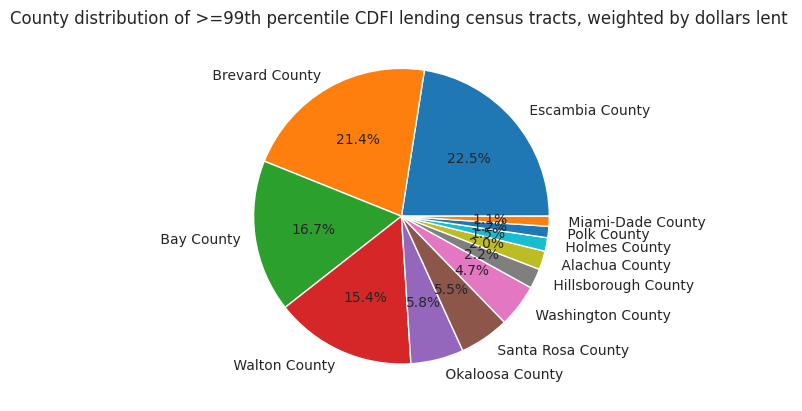

99th percentile census tract CDFI lending is $6.1 million
These tracts get 27.4% of overall CDFI lending for the state of Florida


In [ ]:
top_pct_cutoff=df.loc[:,"total_cdfi_lending"].quantile([0.99]).loc[0.99]
cdf=df.loc[df.total_cdfi_lending>=top_pct_cutoff,["total_population","total_cdfi_lending","county_name"]].groupby("county_name").sum().sort_values("total_cdfi_lending",ascending=False)

fig, ax = plt.subplots()

plt.pie(cdf.total_cdfi_lending,autopct='%1.1f%%',labels=cdf.index)
plt.title("County distribution of >=99th percentile CDFI lending census tracts, weighted by dollars lent ")
plt.show()
print(f"99th percentile census tract CDFI lending is ${top_pct_cutoff/1000000:.1f} million")
print(f"These tracts get {percent_cdfi_funding_in_top_1_percent:0.1f}% of overall CDFI lending for the state of Florida")

We see that four counties get the bulk of this top 1% lending (and so account for >20% of total CDFI lending just from their top 1% census tracts alone).

I found [list of Florida CDFIs](https://www.cdfi.org/wp-content/uploads/2013/02/Florida-1.pdf) to see if any of them were in these "whale" counties, but need to investigate more.

Here are the major cities in these top counties:

*   Escambia County - Pensacola
*   Brevard County - not sure, but is just east of Orlando
*   Bay County - Panama City
*   Walton County - Freeport

Ecambia, Bay, and Walton counties are right by each other in the westernmost part of the Florida panhandle, so perhaps are served by the same CDFI?  I did see a CDFI listed in Pensacola - Community Enterprise Investments Inc. Community South Credit Union, Chipley is also nearby. There are several CDFIs Tallahassee, which is still on the panhandle but a bit further away.

Let's look at just the top 5 lending census tracts..







In [ ]:
display(df.sort_values("total_cdfi_lending",ascending=False).loc[:,["geoid","full_name","total_cdfi_lending"]].head(5))

,geoid,full_name,total_cdfi_lending
1536,12033003400,Census Tract 34; Escambia County; Florida,38078471.0
1527,12033000802,Census Tract 8.02; Escambia County; Florida,35532094.2
2795,12033000801,Census Tract 8.01; Escambia County; Florida,23688062.8
5009,12133970103,Census Tract 9701.03; Washington County; Florida,21679220.0
3813,12009063105,Census Tract 631.05; Brevard County; Florida,20044137.0


We see that the top 3 are all in Escambia County, home to [Pensacola - Community Enterprise Investments Inc](https://ceii-cdc.org/).  Their web site mostly talks about affordable housing and busines microloans. Perhaps these large loans are going towards large multifamily housing developments? (Loans tagged as commercial can include mixed commercial/residential use developments) Perhaps there had been a recent hurricane?

Anyway, all of this is a bit of a diversion from what I'm supposed to be focusing on, but it did get me wondering how fair the allocation of CDFI funding is across counties (not just looking at the top 1% lending census tracts).

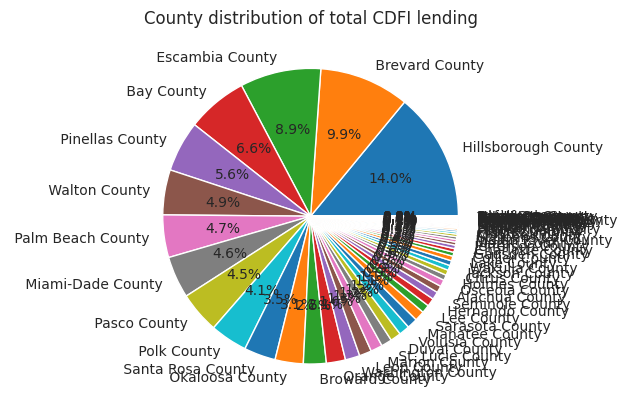

In [ ]:
top_pct_cutoff=df.loc[:,"total_cdfi_lending"].quantile([0.99]).loc[0.99]
cdf=df.loc[:,["total_population","total_cdfi_lending","county_name"]].groupby("county_name").sum().sort_values("total_cdfi_lending",ascending=False)

fig, ax = plt.subplots()

plt.pie(cdf.total_cdfi_lending,autopct='%1.1f%%',labels=cdf.index)
plt.title("County distribution of total CDFI lending")
plt.show()

The above chart isn't pretty, but it shows that lots of counties get a good amount of CDFI lending. Escambia, Brevard, Bay and Walton (which dominated the top 1%) are 4 of the top 6 here.

Interestingly, Hillsborough County gets the most CDFI lending yet had only 2% of the top 1% census tracts. Tampa is in Hillsborough County, and [has several CDFIs](https://www.cdfi.org/wp-content/uploads/2013/02/Florida-1.pdf) (GTE Federal Credit Union, Suncoast Credit Union, Tampa Bay Black Business Investment Corp, Tampa Bay Federal Credit Union).  (Hillborough County is also notable later in the notebook for being effective in getting funding to its high poverty census tracts, and for having the only census tracts in Florida with significant concentrations of cancer-causing particles in the air).

The other thing I was wondering about regarding *num_mortgages_origin* and *total_cdfi_lending* is if the large values for a small fraction of census tracts have anything to do with population.

It makes intuitive sense that census tracts with larger numbers of households would have more mortgages and potentially more CDFI lending (depending on need).



So let's look at a scatter plot of number of households vs number of originated mortages per census tract. Blue dots indicate census tracts that are CDFI Fund Investment Areas. Orange dots are not.

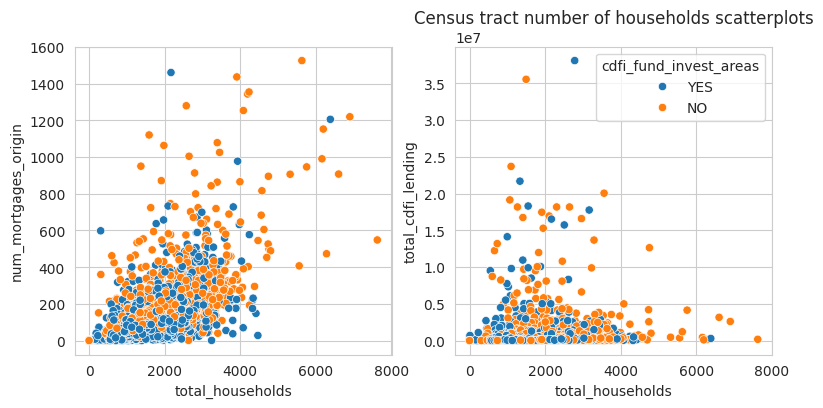

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9,4))

sns.scatterplot(data=df,x="total_households",y="num_mortgages_origin",hue="cdfi_fund_invest_areas",ax=axes[0],legend=False)

sns.scatterplot(data=df,x="total_households",y="total_cdfi_lending",hue="cdfi_fund_invest_areas",ax=axes[1])
plt.title("Census tract number of households scatterplots")
plt.show()


Differing census tracts populations do not appear to be driving the high tail values for number of mortgages or CDFI lending.

Above we some assocation between number of households and number of mortgages, but there are plenty of outliers with moderate numbers of households but large numbers of mortgages. The tracts with > 800 mortgages orginated are overwhelmingly not CDFI fund investment areas.

For CDFI lending, the results are even more extreme. Interestingly, the large values for CDFI lending are almost entirely in tracts with < 4000 households, and are a mix of CDFI fund investment areas and non-investment areas. The census tracts with > 4000 households tend not to be CDFI fund investment areas and have low to modest amounts of CDFI lending.  

It's interesting that CDFI fund investment area census tracts don't seem to get more funding than non-investment area census tracts (i.e. there are plenty of both orange and blue dots as total_cdfi_lending increases). I was puzzled by that until I learned that funding can go to qualified individuals/businesses in any census tract, and that only a certain percentage of CDFI funding needs to go to the target population.

The other thing that occurred to me is that for CDFI lending, total_households may be less relevant than total poor households (or whatever identfies a target population for a CDFI). We will look at socioeconomic data later. But the blue dots indicate investment areas, which are high need areas, and they don't show CDFI lending increasing as number of households increases either. In fact they show the opposite.

I went ahead and snuck a peek at total poor households (total households multiplied by percent below poverty line) below.




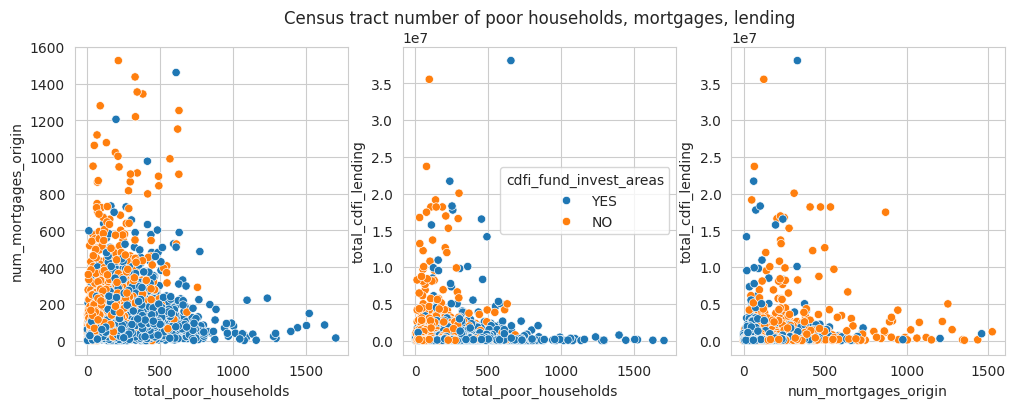

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(12,4))

tdf=df.loc[df.pov_pct_est>0,["total_households","pov_pct_est","cdfi_fund_invest_areas","total_cdfi_lending","num_mortgages_origin"]]
tdf["total_poor_households"]=tdf.total_households*tdf.pov_pct_est/100
sns.scatterplot(tdf,x="total_poor_households",y="num_mortgages_origin",hue="cdfi_fund_invest_areas",ax=axes[0],legend=False)
sns.scatterplot(tdf,x="total_poor_households",y="total_cdfi_lending",hue="cdfi_fund_invest_areas",ax=axes[1])
axes[1].set_title("Census tract number of poor households, mortgages, lending")
sns.scatterplot(df,x="num_mortgages_origin",y="total_cdfi_lending",hue="cdfi_fund_invest_areas",ax=axes[2],legend=False)
plt.show()

In the left two plots, we can see clearly that census tracts with larger numbers of poor households (e.g. > 750) tend to be CDFI investment areas (i.e. blue dots) and have much lower amounts of CDFI lending and number of mortgages than those with fewer poor households. There are CDFI investment areas with large numbers of mortgages, and CDFI investment areas with large amounts of CDFI lending, but they are census tracts with smaller numbers of poor households in them.

The rightmost plot compares mortgages and CDFI lending directly. Interestingly, there are investment areas with large amounts of CDFI lending, and ones with large numbers of mortgages, but they are mutually exclusive. We don't see investment areas with large amounts of both.  

One would hope that CDFI lending would increase the number of mortgages in investment areas! But as we saw earlier, the census tracts with large amounts of CDFI lending may be dominated by real estate and commercial investments. What we really want to see here is amounts of CDFI home mortgage lending and number of CDFI assisted mortgages initiated.  

There may also be some data skew in the CDFI lending numbers due to the 2010 census ids in the source dataset.

Regardless, it looks like census tracts with larger numbers of poor households are currently underserved by CDFI lending. We will see later that many of them are part of other government housing programs such as HUD opportunity zones or HUD qualified census tracts.

Let's start looking at those other government programs now.





## Government Housing Programs

This section explores the relationship between the Dept of Treasury [CDFI Fund Investment Areas](https://home.treasury.gov/policy-issues/small-business-programs/state-small-business-credit-initiative-ssbci/2021-ssbci/cdfi-fund-investment-areas) and census tracts served by other government programs, namely the HUD Low Income Housing Tax Credit (LIHTC) program [Qualified Census Tracts](https://www.huduser.gov/portal/datasets/qct.html) and the HUD [Opportunity Zones Program](https://opportunityzones.hud.gov/) Census Tracts.

It focuses on overlap between these programs and their relationship to mortgages and CDFI lending.

First, let's look at a Venn diagram of CDFI investment area census tracts relative to other CDFI census tract data..




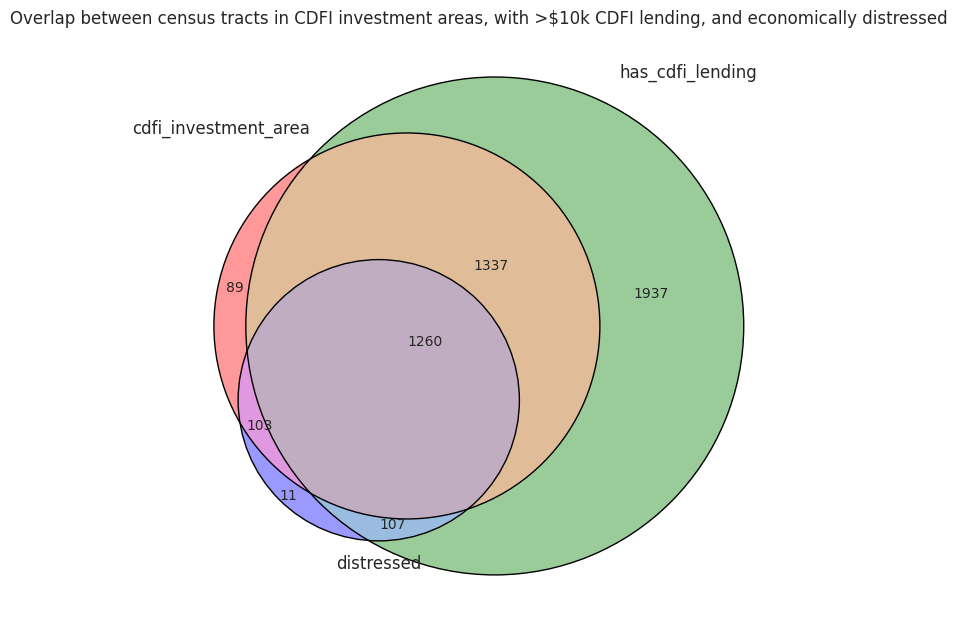

'\nvenn3(\n    df.loc[:,["venn_key2","total_population"]].groupby("venn_key2").sum()["total_population"].to_dict(),\n    subset_label_formatter=lambda x: f"{x/1000:,.1f}k",\n    set_labels=labels,\n    ax=axes[1]\n)\n'

In [ ]:
# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
labels=["cdfi_investment_area","has_cdfi_lending","distressed"]
venn3(
    df.loc[:,["venn_ia_hl_ed","geoid"]].groupby("venn_ia_hl_ed").count()["geoid"].to_dict(),
    set_labels=labels,
#    ax=axes[0]
)

venn3_circles(
    df.loc[:,["venn_ia_hl_ed","geoid"]].groupby("venn_ia_hl_ed").count()["geoid"].to_dict(),
    linewidth=1
)

plt.title("Overlap between census tracts in CDFI investment areas, with >\$10k CDFI lending, and economically distressed")
plt.show()
"""
venn3(
    df.loc[:,["venn_key2","total_population"]].groupby("venn_key2").sum()["total_population"].to_dict(),
    subset_label_formatter=lambda x: f"{x/1000:,.1f}k",
    set_labels=labels,
    ax=axes[1]
)
"""

As mentioned previously, CDFI's need to lend a certain percentage of their funds to their target populations, meaning either individuals who meet certain demographic criteria or live in a census tract designated as a CDFI investment area. Thus, many census tracts get CDFI lending without being investment areas.

* *has_cdfi_lending* - above includes all census tracts that have at least 10,000 dollars in CDFI lending. That number was chosen somewhat arbitrarily, but is meant to ignore census tracts that only have tiny microloans. This comes from 2021 data, and as mentioned before the source data uses 2010 census tract ids.

* *cdfi_investment_area* - is census tracts that are designated as investment areas. There are many factors that go into this including poverty, population loss, unemployment rate. This comes from 2021 data.

* *distressed* - is census tracts marked by columns "cdfi_fund_economic_distress" (v1.1) or "economic_distress_pop_agg" (v1.0) in the DataKind dataset, and called "area_of_economic_distress" in the DataKind eodatascape data dictionary. It also has [a lot of factors that go into it](https://eodatascape.datakind.org/data-dictionary), but luckily it is the first entry in the data dictionary so is easy to find the description. A major factor is at least 20% of households being in poverty. This comes from 2024 data.

In the above Venn diagram, we see that these sets of census tracts are largely nested - most "distressed" tracts are in "cdfi_investment_areas" and most "cdfi_investment_areas" are in "has_cdfi_lending".  This is as we'd hope.

That said, they don't overlap perfectly.  There are 103 census tracts that are distressed and in CDFI investment areas but have negligible CDFI lending.

Let's look at the 11 census tracts that are distressed but have less than 10,000 dollars CDFI lending and are not in investment areas to see if we can figure out what is going on.


In [ ]:
display(df[df.venn_ia_hl_ed == "001"].loc[:,[
    "geoid","county_name","cdfi_fund_invest_areas","opzone","qct","total_population","total_cdfi_lending"]
                                  ].sort_values("county_name"))

,geoid,county_name,cdfi_fund_invest_areas,opzone,qct,total_population,total_cdfi_lending
1309,12011031102,Broward County,NO,0,0,3769,2861.000000
1311,12011040101,Broward County,NO,0,0,1256,2029.715902
1313,12011040506,Broward County,NO,0,0,2201,7912.621990
3855,12011020211,Broward County,NO,0,1,2419,7031.000000
3987,12021010111,Collier County,NO,0,0,2326,4134.666667
4001,12021010520,Collier County,NO,0,0,2151,322.222691
3030,12073001803,Leon County,NO,0,0,811,2669.813384
637,12086006706,Miami-Dade County,NO,0,0,2404,1247.000000
1893,12086007607,Miami-Dade County,NO,0,0,2500,4322.500000
3290,12087971900,Monroe County,NO,0,0,7028,3261.000000



The [CDFI public viewer](https://cimsprodprep.cdfifund.gov/CIMS4/apps/pn-cdfi/index.aspx#?entity=CT_2020_CDFI,12011031102&center=-80.096433,26.241096&level=14&visible=CT_2020_CDFI) is a very useful tool that lets you look up a census tract and get a bunch of information about it related to its CDFI status.

Looking up the first geoid above - 12011031102 - the viewer indicates that it is not qualified as a CDFI investment area due to either poverty rate (is < 20%), median family income, unemployment rate or population loss rate.

The [EODataScape data dictionary](https://eodatascape.datakind.org/data-dictionary) links to the [source dataset for areas of economic distress](https://www.cdfifund.gov/sites/cdfi/files/2024-02/7_FY24_CMF_dataset_final.xlsx). That dataset incidates that geoid is non-rural, is a FY2024 CMF area of economic distress, but not a FY2024 low income area. I'm not entirely sure what the distinction is.

Anyway, it sounds like this could be a case of mismatch between definitions used for investment areas and economic distress, or it could be due to the data coming from different time periods - 2024 for distress and 2021 for cdfi_investment_areas. I'm not sure what year data the CDFI public viewer is using.

It does seem quite possible that there are census tracts deserving of CDFI lending that are not getting much.






---



Lets move on to looking at overlap with other government programs..

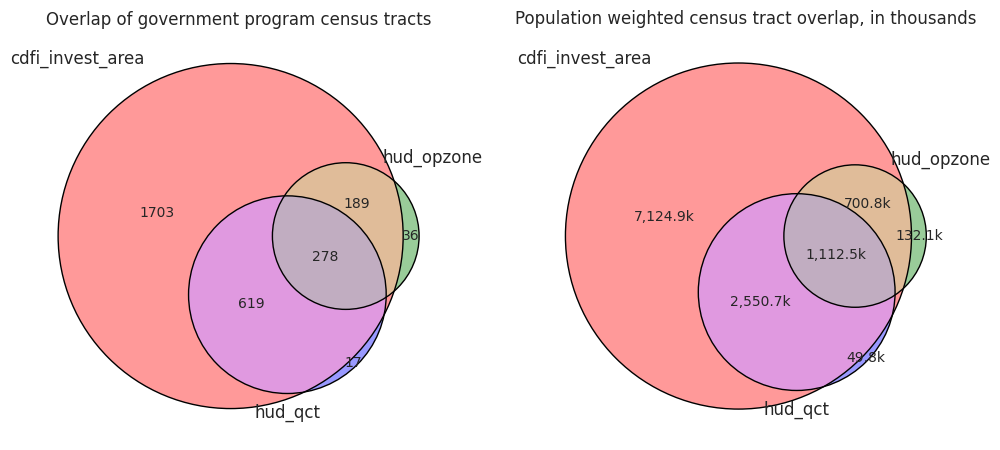

In [ ]:
labels=["cdfi_invest_area","hud_opzone","hud_qct"]

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

d=df.loc[:,["venn_key","total_population"]].groupby("venn_key").count()["total_population"].to_dict()
ax=axes[0]

venn3(d, set_labels=labels, ax=ax)
venn3_circles(d, linewidth=1, ax=ax)
ax.set_title("Overlap of government program census tracts")

d=df.loc[:,["venn_key","total_population"]].groupby("venn_key").sum()["total_population"].to_dict()
ax=axes[1]

venn3(d, set_labels=labels, subset_label_formatter=lambda x: f"{x/1000:,.1f}k", ax=ax)
venn3_circles(d, linewidth=1, ax=ax)
ax.set_title("Population weighted census tract overlap, in thousands")

plt.show()




* *cdfi_invest_area* - is the same as before

* *hud_opzone* - is HUD Opportunity Zone census tracts. This is the "opzone" field in the EODataScape data dictionary, which says that the data is from 2018

* *hud_qct*  - is HUD Low Income Housing Tax Credit (LIHTC) program Qualified Census Tracts. Field "qct" in EODataScape data dictionary, from 2025

Here we see that there are significantly more CDFI investment areas than there are HUD program census tracts, and that most HUD census tracts are also CDFI investment areas. There is also significant overlap between the set of HUD opzone and qct census tracts.

There are some HUD tracts that aren't CDFI investment areas. I haven't looked into whether that is due to the data coming from different years or from their different criteria, but there are relatively few of them.

The diagram on the left indicates the number of census tracts in each subset. (Florida has around 5000 census tracts, but many of those don't belong to any of these programs so are not represented in the diagram).

The diagram on the right gives the number of people in each subset (adding up the populations of the census tracts in each subset).

As we can see, the proportions in each diagram are about the same, so weighting by population doesn't change much.



---



Next, let's look at how the number of households, number of mortgages, and CDFI lending break down between these different programs. We'll make pie charts, so that we can include census tracts that don't belong to any of these programs.

Given that almost all HUD census tracts are also investment areas, we'll combine those that aren't into a single "other" pie slice for display purposes.

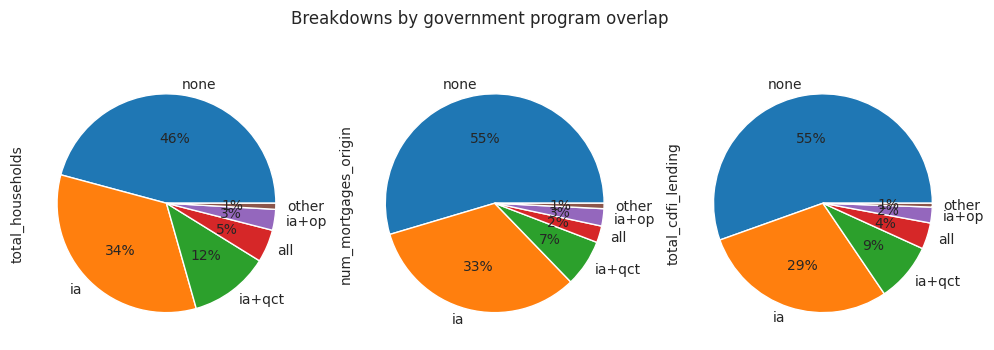

In [ ]:
a=df.loc[:,["overlap_label","total_households","num_mortgages_origin","total_cdfi_lending"]].groupby("overlap_label").sum()
a=a.sort_values("total_households",ascending=False)

a.plot.pie(subplots=True,autopct='%1.0f%%',legend=False,figsize=(12, 4),title="Breakdowns by government program overlap")
plt.show()

The labels mean the following:

* *none* - census tract not in any of the three government programs

* *ia* - CDFI investment area but not in either of the HUD programs

* *ia+qct* - CDFI investment area and HUD Qualified Census Tract but not a HUD Opportunity Zone

* *all* - in all three government programs

* *ia+op* - CDFI investment area and HUD Opportunity Zone but not a HUD Qualified Census Tract

* *other* - everything else (i.e. in a HUD program but not a CDFI investment area)

The chart on the left shows us that over half of Florida households are in census tracts that belong to CDFI investment areas (a signficant share of those are in combination with HUD programs), and 34% of households are in CDFI investment areas exclusively.

When we look at the chart for number of mortgages (the middle chart), we see almost the same percentage of exclusively CDFI investment areas (the orange wedge at 33%). This means that 33% of mortgages are originated in households in such census tracts. (And the chart on the right shows that 29% of CDFI lending goes to such census tracts).

The main difference between the center and left charts is that the blue wedge has grown (to 54% from 46% to) at the expense of the non-orange wedges. i.e over half of mortgages are originated in census tracts belonging to no govenment program, and significantly fewer mortgages are originated in census tracts belonging to at least one HUD program (12% of mortgages from the center chart, vs 20% of households from the left chart).

The chart on the right (total CDFI lending) similarly shows 54% of CDFI lending going to the blue wedge (census tracts with no government program), and 16% of lending going to tracts belonging to at least one HUD program. The orange (CDFI exclusive) wedge has shrunk from 34% to 29%.

The main takeaway from this is that mortgages and CDFI lending disproportionately go to census tracts belonging to no government program (relative to number of households), and that those belonging to HUD programs fare worse than exlucisvely CDFI investment areas, particularly for mortgages.

That said, recall that total CDFI lending and number of mortgages are dominated by a small percentage of census tracts, so looking at the sum across tracts may not give us the whole picture. Let's look at things another way next.




---



Instead of looking at totals, let's look at the distribution of mortgage origination, and CDFI lending, and households, broken down by government program.

To make things easier to visualize, we use the percentiles for mortgages and CDFI lending rather than the absolute values.

We also combine the two hud programs together so census tracts fall into one of three categories:  none, CDFI investment area exlusively, and HUD.


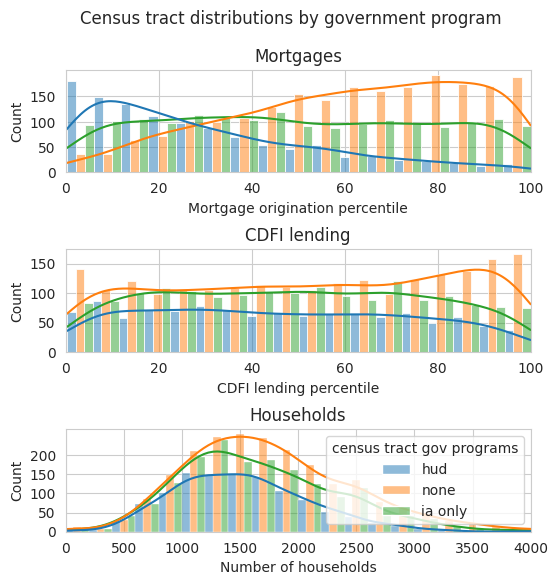

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6))
plt.subplots_adjust(hspace=0.75)
ax=axes[0]
sns.histplot(
    data=df,
    x="pctile_mortgages_origin_fl",
    hue="overlap_label2",
    multiple="dodge",
    cumulative=False,
    legend=False,
    kde=True,
    ax=ax
)
ax.set_title("Mortgages")
ax.set_xlim(xmin=0,xmax=100)
ax.set(xlabel="Mortgage origination percentile")
ax.set_yticks(np.arange(0, 200, 50))

ax=axes[1]
sns.histplot(
    data=df,
    x="pctile_cdfi_lending_fl",
    hue="overlap_label2",
    multiple="dodge",
    cumulative=False,
    kde=True,
    legend=False,
    ax=ax
)
ax.set_title("CDFI lending")
ax.set_xlim(xmin=0,xmax=100)
ax.set(xlabel="CDFI lending percentile")
ax.set_yticks(np.arange(0, 200, 50))

ax=axes[2]
sns.histplot(
    data=df.rename(columns={'overlap_label2': 'census tract gov programs'}),
    x="total_households",
    hue="census tract gov programs",
    binrange=(0,4000),
    binwidth=200,
    multiple="dodge",
    cumulative=False,
    kde=True,
    ax=ax
)
ax.set_xlim(xmin=0,xmax=4000)
ax.set_title("Households")
ax.set(xlabel="Number of households")
ax.set_yticks(np.arange(0, 250, 50))

plt.suptitle("Census tract distributions by government program")
plt.show()

In the charts above, the y axis is the number of census tracts in a given histogram bucket. For the first two histograms, each bucket corresponds to 5 percentile points. The color indicates which government programs the census tracts belong to:

* blue - at least one HUD program
* orange - none
* green - CDFI investment area and not HUD

For example, in the mortgages chart (the top one) we see that there are approximately 175 HUD census tracts (blue) in the 0-5th percentile of mortgage origination, and less than 25 in the 95-100th percentile. The percentiles are relative to all census tracts in the dataset (i.e. Florida census tracts).

**mortgages**

From the mortgages chart, we can see pretty clearly that as the mortgage origination percentile (the x axis) increases, the number of HUD census tracts decreases and the number of "none" tracts increases. i.e HUD census tracts aren't likely to originate many mortgages, but "none" tracts are.

Similarly, we see that just over half of the census tracts with the lowest percentile of mortgages are HUD tracts (approximately 175 HUD, 100 investment areas only, 40 none). This means there is still a significant fraction of low mortgage census tracts not covered by HUD programs.  The highest percentile tracts are dominated by "none".

The exclusively CDFI investment area "ia only" (green) census tracts are remarkably evenly distributed, with around 100 census tracts per mortgage percentile bucket, implying that being in a CDFI investment area but not HUD program doesn't have much to do with number of mortgages originated.  

**CDFI lending**

Looking at the second chart, for CDFI lending, we see that the highest percentiles of lending are dominated by "none" tracts, too. The number of "none" tracts increases at the higher percentiles, whereas the number of "ia only" and "hud" tracts decreases. Also recall that the 99th percentile of CDFI lending census tracts account for over 27% of total CDFI lending.

We also see a lot of "none" tracts at the 0-5th percentile of CDFI lending.

The "ia only" tracts are pretty evenly distributed, but drop of at the lowest and highest percentiles of CDFI lending.

**households**

The last chart, with number of households, shows that the distribution of number of households is pretty similar across programs, though HUD tends to skew a bit smaller and "none" a bit larger

**Future Work**

Instead of looking at mortgage origination percentiles, it might be better to look at per-household mortgage origination rate percentiles - i.e. divide num_mortgages_originated by total_households and then compute percentiles based on that. I've run out of time, though. This is the last day of the DataKit and I'm scrambling to get everything cleaned up and submitted.

## Poverty and Race

Now let's look at how poverty and race intersect with government housing programs.

We rely on poverty and race statistics in EODataScape dataset that are sourced from the 2022 US Census American Community Survey (5-year estimates) according to the [EODataScape data dictionary](https://eodatascape.datakind.org/data-dictionary)

In particular, we use fields for the percent of people below poverty level, the percent of people of a given race, and the percent of people of a given race below the poverty level.

First we do a bit of data cleanup, dropping rows with negative values for these fields (there aren't many) and adding some new columns based on these fields.

In particular, we compute poor and non-white populations by multplying the provided percentages by the total populations of the census tracts


In [ ]:

display("dropping rows with unknown demographics")
display(df.shape)
df.drop(df[df.pov_white_nh_pct_est<0].index,inplace=True)
df.drop(df[df.pov_pct_est<0].index,inplace=True)
df.drop(df[df.pop_pct_white<0].index,inplace=True)

display(df.shape)

display("adding columns for non-white and poor populations")

df["pop_pct_nonwhite"]=100-df.pop_pct_white
df["pov_nonwhite_pct_est"]=df.apply(
    lambda x: 0 if x.pov_white_nh_pct_est>=x.pov_pct_est else (x.pov_pct_est-x.pov_white_nh_pct_est),
    axis=1)
df["non_white_population"]=((100-df.pop_pct_white)*df.total_population//100)
df["poor_population"]=(df.pov_pct_est*df.total_population//100)
df["poor_non_white_population"]=df.apply(
    lambda x: 0 if x.pov_white_nh_pct_est>=x.pov_pct_est else (x.pov_pct_est-x.pov_white_nh_pct_est)*x.total_population/100,
    axis=1)


'dropping rows with unknown demographics'

(5011, 396)

(4988, 396)

'adding columns for non-white and poor populations'

Now lets look at some pie charts

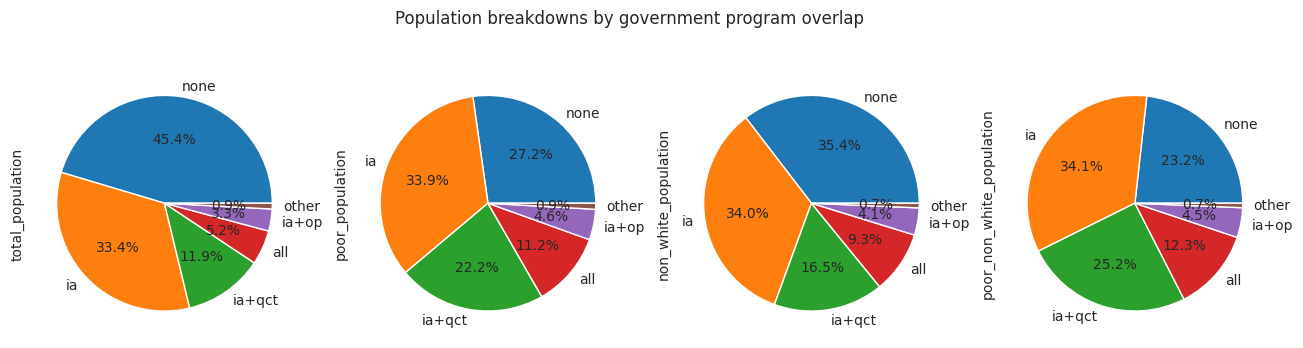

In [ ]:

sns.set_style("whitegrid")
#fig, axes = plt.subplots(1, 3, figsize=(16, 4))

a=df.loc[:,["overlap_label","total_population","poor_population","non_white_population","poor_non_white_population"]].groupby("overlap_label").sum()
a=a.sort_values("total_population",ascending=False)
a.plot.pie(subplots=True,autopct='%1.1f%%',legend=False,figsize=(16, 4),title="Population breakdowns by government program overlap")
plt.show()

The above pie charts take an entire population and shows what percentage of that population lives in census tracts that belong to different government programs. The government program labels and color scheme are the same as used in our earlier pie charts.

The leftmost chart looks at the entire population of Florida. It is comparable to the leftmost pie chart in our earlier diagram (which was based on households), with 45% of people in no government program (blue), and 33% in CDFI investment areas but no HUD program (orange).

The chart to its right looks at "poor_population", meaning only people living below the poverty level. We see that the percentage of people living in a census tract with no government programs shrinks down to 27.2%, with almost all of the growth coming from tracts that are both HUD Qualfied Census Tracts and CDFI Investment Areas (green) and tracts belonging to all three programs (red).

The next chart to the right looks at "non_white_population" which means all people who did not report as white non-hispanic in the census data. It shows the same trend as the "poor_population" chart but to a lesser extent.

The rightmost chart is "poor_non_white_population", and counts only non-white people living below the povery level. It has 23% of people living in census tracts not covered by any government program (the blue wedge), the least amongst all the charts but still a significant percentage.

This demonstrates the importance of CDFI lending to people in need who live outside of CDFI investment areas (as well as those who live inside them). Note that less than half of poor non-white people live in HUD program census tracts (green, red, purple, brown), so there is a great need for CDFI lending.

Interestingly, all of the pie charts show about the same percentages for the people living in CDFI investment area only tracts (orange).





---



Next, lets look at distributions of poor and non-white populations over census tracts

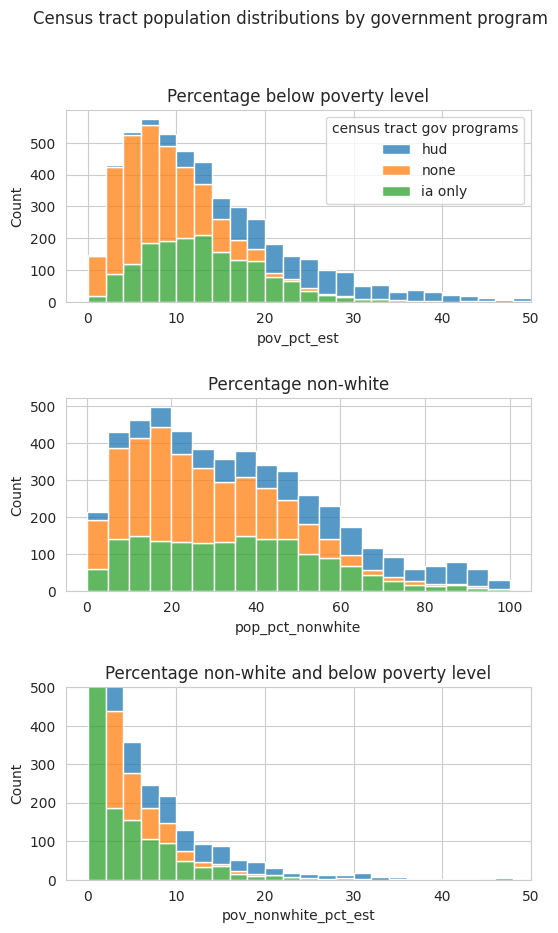

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(6, 10))
plt.suptitle("Census tract population distributions by government program")
plt.subplots_adjust(hspace=0.5)
sns.set_style("whitegrid")
ax=axes[0]
sns.histplot(
    data=df[df.pov_pct_est>=0].rename(columns={'overlap_label2': 'census tract gov programs'}),
    x="pov_pct_est",
    hue="census tract gov programs",
    binrange=(0,50),
    binwidth=2,
    multiple="stack",
    legend=True,
    ax=ax
)
ax.set_xlim(xmax=50)
ax.set_yticks(np.arange(0, 600, 100))
ax.set_title("Percentage below poverty level")

ax=axes[1]
sns.histplot(
    data=df[df.pop_pct_white>=0],
    x="pop_pct_nonwhite",
    hue="overlap_label2",
    multiple="stack",
    legend=False,
    binrange=(0,100),
    binwidth=5,
    ax=ax
)
ax.set_title("Percentage non-white")
ax.set_yticks(np.arange(0, 600, 100))

ax=axes[2]
sns.histplot(
    data=df,
    x="pov_nonwhite_pct_est",
    hue="overlap_label2",
    binrange=(0,50),
    binwidth=2,
    multiple="stack",
    legend=False,
    ax=ax
)
ax.set_xlim(xmax=50)
ax.set_ylim(ymax=500)
ax.set_title("Percentage non-white and below poverty level")
plt.show()

The above histograms are similar to the ones we did earlier for mortgages and CDFI lending, using the same colors and labels. However, now the x axis is percentages instead of percentiles, and the different colors for a histogram bucket are now stacked on top of each other.  

For example, in the top chart we see that there are just over 450 census tracts with between 10-12% of the population living below the poverty level.  200 of these are investment areas but not HUD, another 210 or so belong to no government program, and perhaps 50 are HUD (qualified census tract or opportunity zone).  

When we look at the 20-22% poverty bucket, we see about 180 census tracts split pretty evenly between HUD and investment areas. Almost all census tracts with >= 20% poverty are part of some government program.  Almost all with >=30% poverty are part of HUD programs. The bucket with the largest number of census tracts is 6-8% poverty.

When we look at the middle chart, we see the peak of 500 census tracts at 15-20% non-white (each bucket in this chart is 5% of population). The number of "none" tracts per bucket starts dropping off after that whereas the number in "hud" tracts starts increasing. The number of investment area tracts per bucket holds steady until about 50% and then starts dropping. At higher percentages almost every census tract is part of a government program.

Looking at poor non-white populations (the last chart), the peak is at 0-2% and the drop-off is even sharper.





---



Let's try to better understand the relationship between race and poverty, and the distribution of census tracts that lack CDFI lending

Text(0.5, 1.0, 'Tracts without CDFI lending')

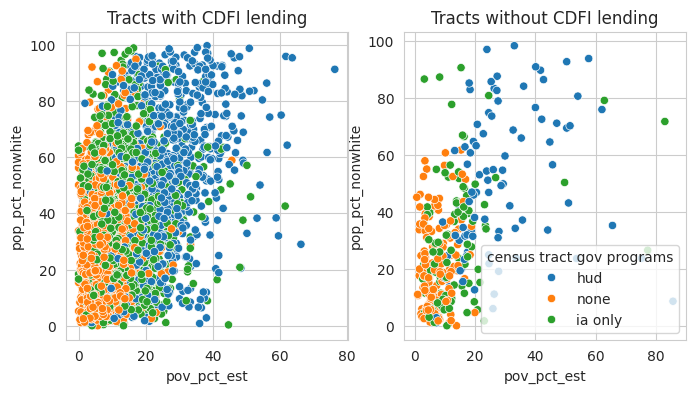

In [ ]:
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
sns.scatterplot(df[df.has_cdfi_lending==1].rename(columns={'overlap_label2': 'census tract gov programs'}),
                x="pov_pct_est",y="pop_pct_nonwhite",hue="census tract gov programs",ax=axes[0],legend=False)
axes[0].set_title("Tracts with CDFI lending")
sns.scatterplot(df[df.has_cdfi_lending==0].rename(columns={'overlap_label2': 'census tract gov programs'}),
                x="pov_pct_est",y="pop_pct_nonwhite",hue="census tract gov programs",ax=axes[1])
axes[1].set_title("Tracts without CDFI lending")

The scatterplot on the left includes all census tracts that have at least 10,000 dollars in CDFI lending. The plot on the right contains tracts that have less than 10,000 dollars in lending.

The x axis is the percentage of people living below poverty level in a census tract. The y axis is the percentage of people who are non-white (Hispanic is counted as non-white for these purposes). The color of a dot indicates which government programs the census tract belongs to, if any.

As expected, we see that almost all census tracts belonging to no government program (orange dots) have below 20% poverty levels.

We see most census tracts are below 30% poverty and below 60% non-white.

When we look at poverty percentages above 30%, we see a much higher proportion of 60-100% non-white census tracts than we see at lower poverty levels.

These patterns apply to both plots.  

Notably, we see that the high poverty census tracts lacking CDFI funding are mostly greater than 40% non-white, with many over 60% non-white.






---



That makes me curious about the distribution of high poverty census tracts lacking CDFI lending.  Here we look at the breakdown of these tracts by county.

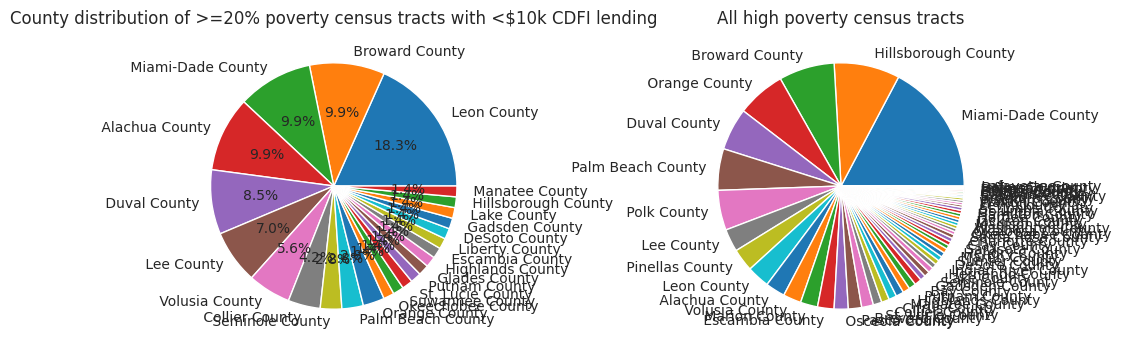

In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12, 4))

ax=axes[0]
cdf=df.query("has_cdfi_lending==0 and pov_pct_est>=20").loc[:,["total_population","county_name"]].groupby("county_name").count().sort_values("total_population",ascending=False)
#plt.pie(cdf.total_population,autopct='%1.1f%%',labels=cdf.index)
cdf.rename(columns={"total_population":""}).plot.pie(y=0,ax=ax,legend=False,title="foo",ylabel=None,autopct='%1.1f%%')
ax.set_title("County distribution of >=20% poverty census tracts with <$10k CDFI lending")

ax=axes[1]
cdf=df.query("pov_pct_est>=20").loc[:,["total_population","county_name"]].groupby("county_name").count().sort_values("total_population",ascending=False)
#plt.pie(cdf.total_population,autopct='%1.1f%%',labels=cdf.index,ax=ax)
cdf.rename(columns={"total_population":""}).plot.pie(y=0,ax=ax,legend=False)
ax.set_title("All high poverty census tracts")

plt.show()



 (Sorry these charts are a bit messy and don't have consistent color schemes. I ran out time to polish them)

The chart on the left looks at high poverty census tracts lacking CDFI lending.
 For comparison, the chart on the right looks at all high poverty census tracts.

 On the left, we see 4 counties make up almost half of the high poverty census tracts lacking CDFI lending, with Leon County alone contributing 18%.

 Interestingly, Leon County has only a small percentage of high poverty census tracts overall, so they are doing much worse than other counties at getting CDFI lending to their high poverty census tracts. Tallahassee is in Leon County and has multiple CDFIs, so it seems surprising to me that they aren't getting lending.  Alachua County also isn't doing very well.

 Conversely, we see on the right that Hillsborough County has the second highest percentgage of high poverty census tracts and yet on the left has the second lowest percentage of high poverty census tracts lacking CDFI lending. So it is doing a great job getting lending to those who need it. Recall that Hillsborough County was notable earlier in this document for having the highest percentage of total CDFI lending. Tampa is in Hillsborough County.  Orange County is also doing well at getting lending to its high poverty census tracts.

 Miami-Dade, Broward, and Duval counties are high in both charts.



## Environmental Risk Factors

[DataKind housing challenge 3](https://github.com/datakind/datakit-housing-fall-2024/discussions/3) asks us to:

>Explore housing development variables alongside environmental variables from the EODataScape such as those sourced from the EPA Environmental Justice program: traffic proximity, hazardous waste proximity, air toxics cancer risk and the First Street Foundation: risk of flood, risk of fire.

Let's do that now.

First we do a bit more dataset manipulation, dropping a small number of census tracts that have impossible values for flood and fire risk.

We also create some new columns that will be helpful for visualization purposes.

In [ ]:
df.rename(columns={
    'flood_risk_30yr_pctile': 'flood_risk_30yr_share_pctile',
    'fire_risk_30yr_pctile': 'fire_risk_30yr_share_pctile'
    },inplace=True)
# drop impossible values
display("dropping rows with impossible fire or flood shares")
display(df.shape)
df.drop(df[df.flood_risk_30yr_share>100].index,inplace=True)
df.drop(df[df.fire_risk_30yr_share>100].index,inplace=True)
display(df.shape)

#df["flood_risk_30yr_share"]=df["flood_risk_30yr_share"].map(lambda x: 100 if x>100 else x)
#df["fire_risk_30yr_share"]=df["fire_risk_30yr_share"].map(lambda x: 100 if x>100 else x)

# make buckets
df["mortgages_pctile_bucket"]=df.pctile_mortgages_origin_fl.apply(lambda x: 0 if x< 50 else (50 if x<90 else 90))
df["cdfi_lending_pctile_bucket"]=df.pctile_cdfi_lending_fl.apply(lambda x: 0 if x< 50 else (50 if x<90 else 90))
for col in ["traffic_prox_pctile", "haz_waste_prox_pctile","air_toxics_cancer_pctile","flood_risk_30yr_share_pctile","fire_risk_30yr_share_pctile"]:
    df[f"{col}_bucket"]=df[col].apply(lambda x: 0 if x< 50 else (50 if x<90 else 90))

'dropping rows with impossible fire or flood shares'

(4988, 401)

(4938, 401)

Now lets look at flood and fire risks.

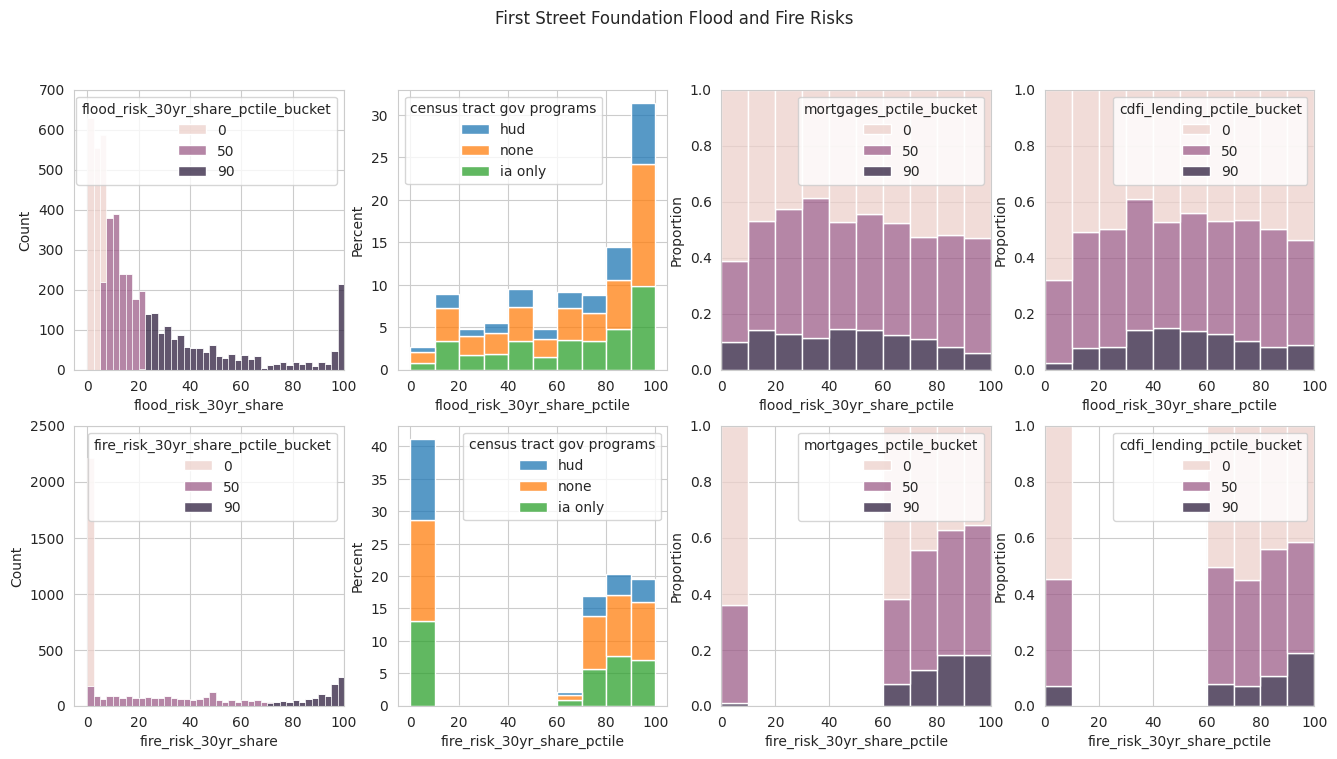

In [ ]:
cols=["flood_risk_30yr_share","fire_risk_30yr_share"]

collim={
    "flood_risk_30yr_share":{"xmax":100,"ymax":700},
    "fire_risk_30yr_share":{"xmax":100,"ymax":2500}
}

# function to make nice plots, one row per environmental hazard
# inputs are:
#   the list of hazards to include,
#   a dictionary with x and y limits to use,
#   title
#   optional number of bins
def plot_environmental_risk_distributions(cols,collim,title,nbins=40):
  hues=["census tract gov programs","mortgages_pctile_bucket","cdfi_lending_pctile_bucket"]
  ncols=len(hues)+1
  nrows=len(cols)
  sns.set_style("whitegrid")
  fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4))

  for i, ax in enumerate(axes.flat):
    j=i//ncols
    k=i%ncols
    col=cols[j]
    if k==0:
      xmax=collim[col]["xmax"]
      bw=xmax/nbins
      sns.histplot(data=df,x=col,hue=f"{col}_pctile_bucket",multiple="stack",binrange=(0,xmax),binwidth=bw,ax=ax)
      ax.set_ylim(ymax=collim[col]["ymax"])
      ax.set_xlim(xmax=xmax)
    elif k==1:
      sns.histplot(data=df.rename(columns={'overlap_label2': 'census tract gov programs'}),x=f"{col}_pctile",hue=hues[k-1],multiple="stack",binrange=(0,100),binwidth=10,stat="percent",ax=ax)
    else:
      sns.histplot(data=df,x=f"{col}_pctile",hue=hues[k-1],multiple="fill",binrange=(0,100),binwidth=10,stat="proportion",ax=ax)

  plt.suptitle(title)
  plt.show()

# use our new function to plot fire and flood risks
plot_environmental_risk_distributions(cols,collim,"First Street Foundation Flood and Fire Risks",40)

The top row has flood risks, and the bottom row has fire.  Detailed descriptions can be found in the [Climate and Economic Justice Screening Tool documentation](https://screeningtool.geoplatform.gov/en/methodology#flood-risk), but roughly the flood and fire risk variables represent the share (percentage) of properties in a census tract that are at risk of flood or wildfire over the next 30 years. Their values range from 0 to 100. The data is from 2020 and sourced from the Climate and Economic Justice Screening Tool (CEJST). In the EODataScape, the field we are using are called:
* share_of_properties_at_risk_of_flood_in_30_years
* share_of_properties_at_risk_of_flood_in_30_years_percentile
* share_of_properties_at_risk_of_fire_in_30_years
* share_of_properties_at_risk_of_fire_in_30_years_percentile

The percentiles are computed nationally (unlike the percentiles we were looking at earlier which we computed ourselves over just the census tracks in our Florida dataset).

**left**

On the left we see histograms of these risk variables, where the y axis is number of census tracts with a given value. For example for floods we see that there are over 200 census tracts with 98-100% of its properties at risk of flood in the next 30 years, and over 600 census tracts with 0-2% of properties at risk of flood.  For fire, we see that over 2000 census tracts have 0-2% of properties at risk.

The colors indicate the percentile risk. E.g. we see that a flood risk share \>20 puts a census tract above the 90th percentile nationally. The buckets are 0-50th percentile, 50-90th, and 90-100th. For fire, we see that a risk share \>2 puts a census tract above 50th percentile nationally.

**middle left**

To the right of these we see the blue, orange and green histograms. The y axis is percentage of census tracts, instead of absolute number. For the x axis they use the flood and fire risk share national percentiles (the same thing used to color the leftmost histograms). For example, we see that over 30% of Florida census tracts are in the 90-100th percentile for flood risk nationally.  The colors indicate the breakdown by government housing program. e.g. 10% of census tracts are CDFI investment areas exclusively (green) and in the 90-100th percentile risk for flooding.

For fire (the bottom row), we see a big gap between 10-60th percentile. The leftmost chart tells us why - anything above the lowest possible risk puts a census tract above the 50th percentile nationally.

**right**

The histograms on the right use the same national percentile x axis as the middle left histogram. The difference is that the histogram display was set to "fill", so each histogram bucket gets stretched up to the top. This makes it a bit easier to compare the proportions of each color between buckets.

For the center right histogram, we color based on mortgage origination percentile. Census tracts that are 0-50th percentile (state wide) are light purple, 50-90th medium purple, and \>90th dark purple.  Thus, if things were evenly distributed, all the dark purple buckets would have their tops at y=0.1 and medium purple would go from y=0.1 to 0.5

The far right histogram is similar, but uses total CDFI lending percentiles instead of mortgages for the coloring.

**analysis**

Whew! That was a lot of setup! So what do we see?

Unsurprisingly, Florida has a disproportionate percentage of census tracts at high flood risk (around 45% of tracts are \>80th percentile risk nationally). Interestingly, it also has a disproportionate percentage of census tracts at high fire risk (almost 40% are \>80th percentile risk nationally).

We see a mix of government programs at all flood and fire risk percentiles. Interestingly, almost a third of the lowest fire risk tracts are HUD, a much higher proportion than at the higher fire risk percentiles (and about 12% of census tracts overall).

Looking at the mortgages and CDFI lending, we see that they favor high fire risk areas. The >80th percentile fire risk tracts have a disproportionate amount of high mortgage and CDFI lending percentile census tracts (e.g. 20% of tracts in those buckets are \> 90th percentile for mortgages, and 20% of tracts that are \>90th percentile fire risk are \>90th percentile for CDFI lending). We see almost no high percentile mortgage lending tracts (dark purple) below 50th percentile fire fisk.

For floods, the mortgage and CDFI lending percentiles are more evenly distributed. We do see a dip in both mortgages and lending in the 0-10th percentile flood risk bucket, but only about 3% of total census tracts are in that bucket.




---



Now let's so the same analysis for some EPA Environmental Risk Factors.  We'll look at hazardous waste proximity, traffic proximity, and air toxics cancer risk.  

This data comes from the Environmental Protection Agency for their EJScreen (Environmental Justic Screen) tool.

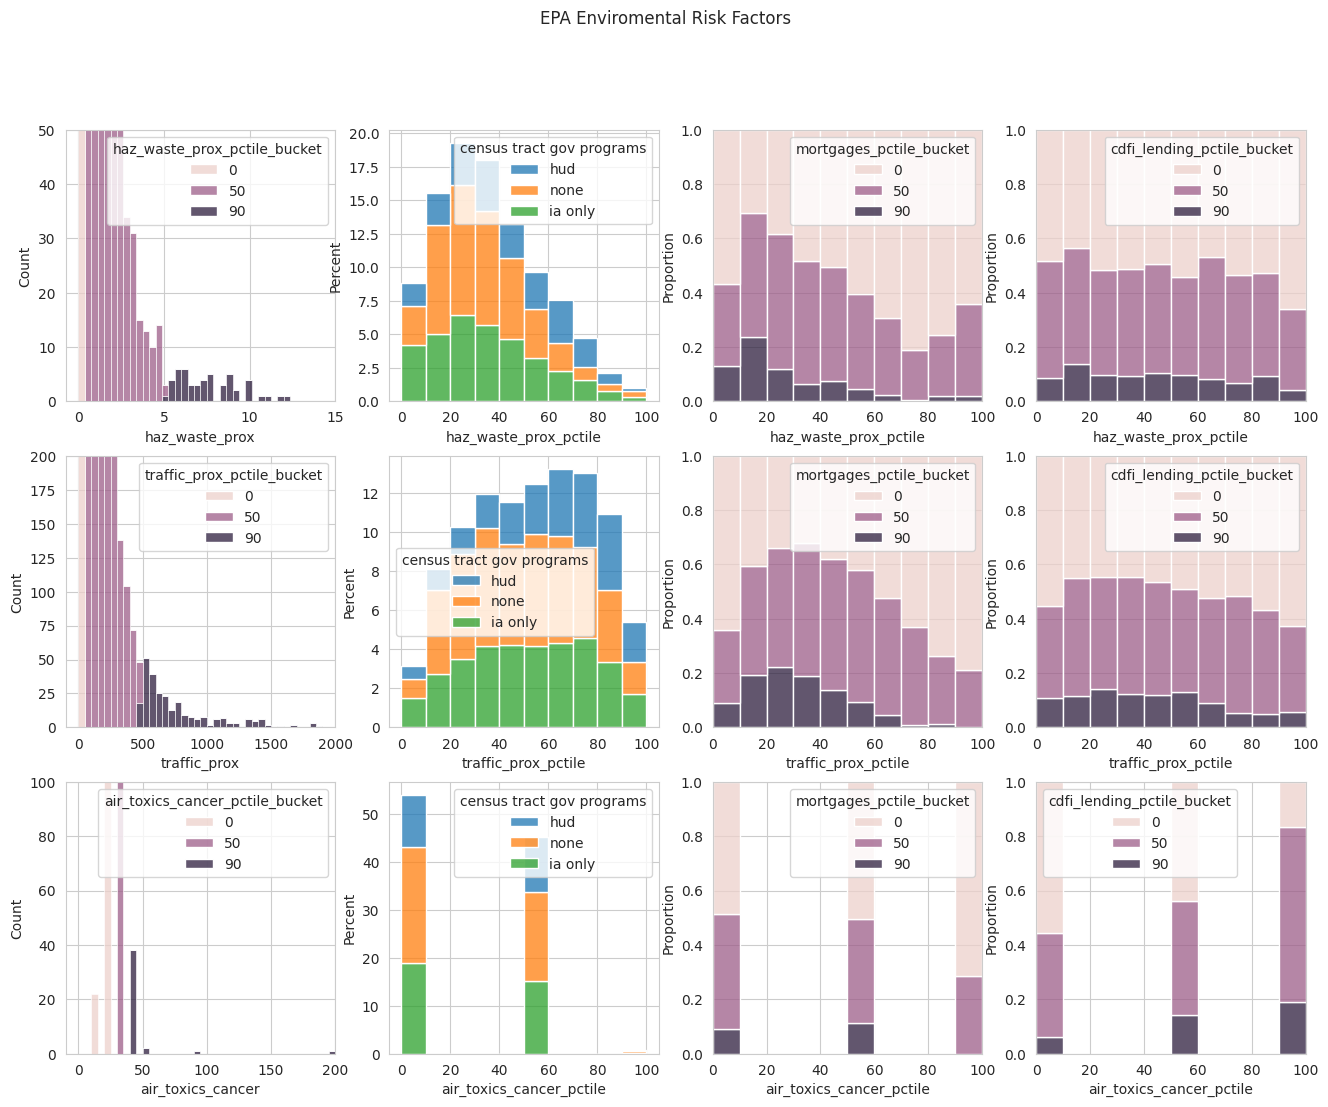

In [ ]:
cols=["haz_waste_prox","traffic_prox","air_toxics_cancer"]

collim={
    "haz_waste_prox":{"xmax":15,"ymax":50},
    "traffic_prox":{"xmax":2000,"ymax":200},
    "air_toxics_cancer":{"xmax":200,"ymax":100}
}

plot_environmental_risk_distributions(cols,collim,"EPA Enviromental Risk Factors",40)

Details about what exactly these environmental risk variables mean can be found on the [EPA EJScreen website](https://www.epa.gov/ejscreen/download-ejscreen-data).

The histograms above use the exact same template that we just discussed at length for fire and flood risk, so see the discussion there for details about how to interpret them. So what do we see?

**hazardous waste**

Hazardous waste proximity is based on how many Superfund sites are within 10 miles of a census tract, and the distance to each. From the leftmost chart we see that nationally, 50% of census tracts are in the lowest percentile bucket (so no nearby Superfund sites). We can tell this because the medium purple starts at the 2nd bucket.

In the next chart over we see that Florida does much better than the national average for hazardous waste proximity, especially at higher proximity percentiles. (If it matched the national average, every percentile bucket would have a y value of 10%). At higher hazardous waste proximity percentiles, a larger share of census tracts are covered by at least one government program (i.e. there is proportionally less orange "none")

We see that mortgages are concentrated at the lower risk hazardous waste proximity percentiles. CDFI lending seems pretty even. It drops off at the 90-100th percentile, but that is only about 1% of census tracts.

**traffic**

For traffic proximity, we see a pretty similar pattern as for hazardous waste. 50% of tracts nationally have negligible traffic proximity.

Florida looks pretty close to to the national average when looking at traffic proximity percentiles (most are between 8% and 13%, whereas the national average would be 10%). It is only at the lowest and highest percentile buckets (0-10%, and 90-100%) that it is significantly lower than national averages. The higher percentiles have a higher proportion of HUD census tracts than the lower percentiles.

Again, mortgages are concentrated at the lower traffic proximity percentiles. CDFI lending also drops off as traffic proximity increases.

**air toxics cancer risk**

The cancer risk is measured by parts per million of cancer causing particles. Looking at the data, the measurements are all multiples of 10.

We see that a measurement of 10 or 20 puts a census tract in the 0-50th percentile nationally, 30 in the 50-90th percentile, and 40 or higher in the 90-100th percentile.  

Florida is far below the national average for high percentiles of cancer risk, but does have a census tract with 200 parts per million of carcinogenic particles, which is 10x the national median concentration.

Mortgage rates are lower and CDFI lending is higher in the 90-100th percentile air toxics cancer risk bucket, though this is a small percentage of Florida census tracts (around 40 of Floridas approximately 5000 census tracts are in the 90-100th national percentile).





This makes me very curious about these high air toxics cancer census tracts (those with >= 50 parts per million).  They are all in Hillsborough County and in the 93rd percentile nationally. Here they are..

In [ ]:
display(df.loc[df.air_toxics_cancer>40,["geoid","full_name","air_toxics_cancer","air_toxics_cancer_pctile","investment_areas","qct","opzone"]]
        .sort_values("air_toxics_cancer",ascending=False))


,geoid,full_name,air_toxics_cancer,air_toxics_cancer_pctile,investment_areas,qct,opzone
1604,12057010810,Census Tract 108.10; Hillsborough County; Florida,200.0,93.0,0,0,0
336,12057010811,Census Tract 108.11; Hillsborough County; Florida,90.0,93.0,1,0,0
2890,12057010809,Census Tract 108.09; Hillsborough County; Florida,50.0,93.0,1,1,0
4159,12057010701,Census Tract 107.01; Hillsborough County; Florida,50.0,93.0,0,0,0
